In [1]:
from next_step import NextStepWinsorize
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.base import clone

### Detecting Outliers

In [2]:
coin = 'XRP'

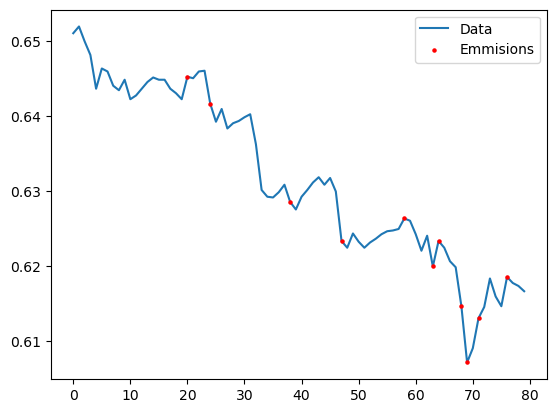

In [3]:
data = np.array(pd.read_csv('price.csv')[coin])
wins = NextStepWinsorize()

wins.fit_transform(data)
wins.show_outliners()

### Outlier Cleaning (Smoothing)

Since removing outliers would lead to a loss of equidiscernibility and a 15% loss, it is better to smooth the outliers to the boundary.

By the way, it is important to note that we consider the course not as the course itself, but as a change in price.

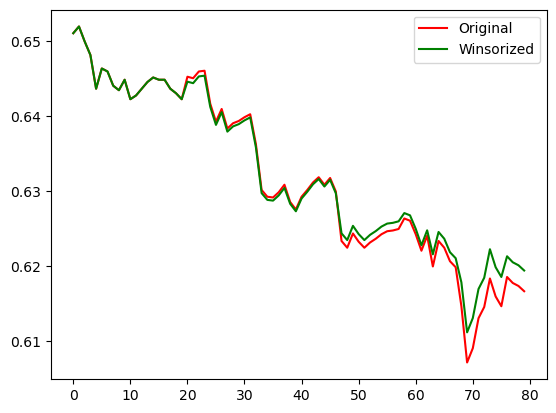

In [4]:
wins.show_winsorized()

### Next, I will create a model based on the outlier detection class.

Here, I will modify the class by adding a field to store characteristics. The investigation will be carried out in the file `model_develop.ipynb`, and then I will transfer it to `next_step`.

In other words, initially, I will make it so that when calling `NextStepWinsorize.fit_transform()`, I save the boundaries for the starting steps in the `previous_steps` field, and in `next_steps`, I will store possible steps for further actions, which I will describe in `model_develop.ipynb`.

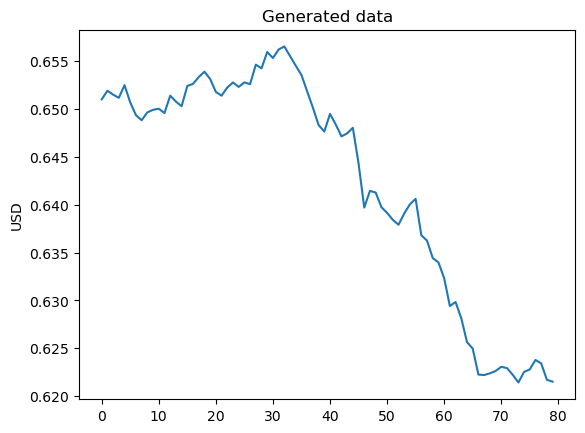

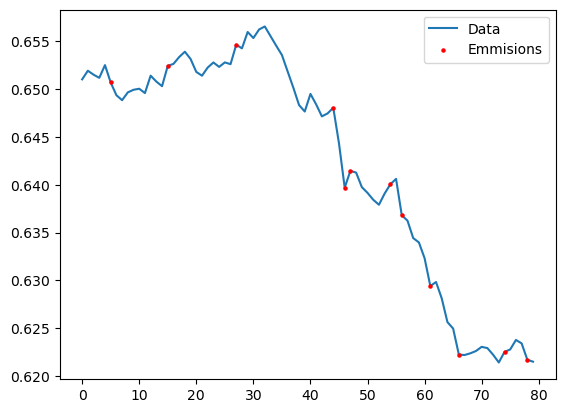

In [5]:
generated_data = wins.generate_data(N=80, emmisions=True, prob=0.2)
wins.show_generated_data()
new_wins = NextStepWinsorize()
new_wins.fit_transform(generated_data)
new_wins.show_outliners()

### Now, I will create a polynomial model.

In [6]:
y = generated_data
X = np.arange(0, y.shape[0])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

min_diff = np.inf
min_d = 0
for i in range(1, 10):
    poly = PolynomialFeatures(degree=i)
    lr = LinearRegression()
    pipeline = make_pipeline(poly, lr)

    pipeline.fit(X_train.reshape(-1, 1), y_train)
    predictions_train = pipeline.predict(X_train.reshape(-1, 1))
    mse_train = mean_squared_error(y_train, predictions_train)

    predictions_test = pipeline.predict(X_test.reshape(-1, 1))
    mse_test = mean_squared_error(y_test, predictions_test)

    mse_diff = abs(mse_train - mse_test)

    min_diff = min(mse_diff, min_diff)
    if min_diff == mse_diff:
        min_d = i

print(min_d)

2


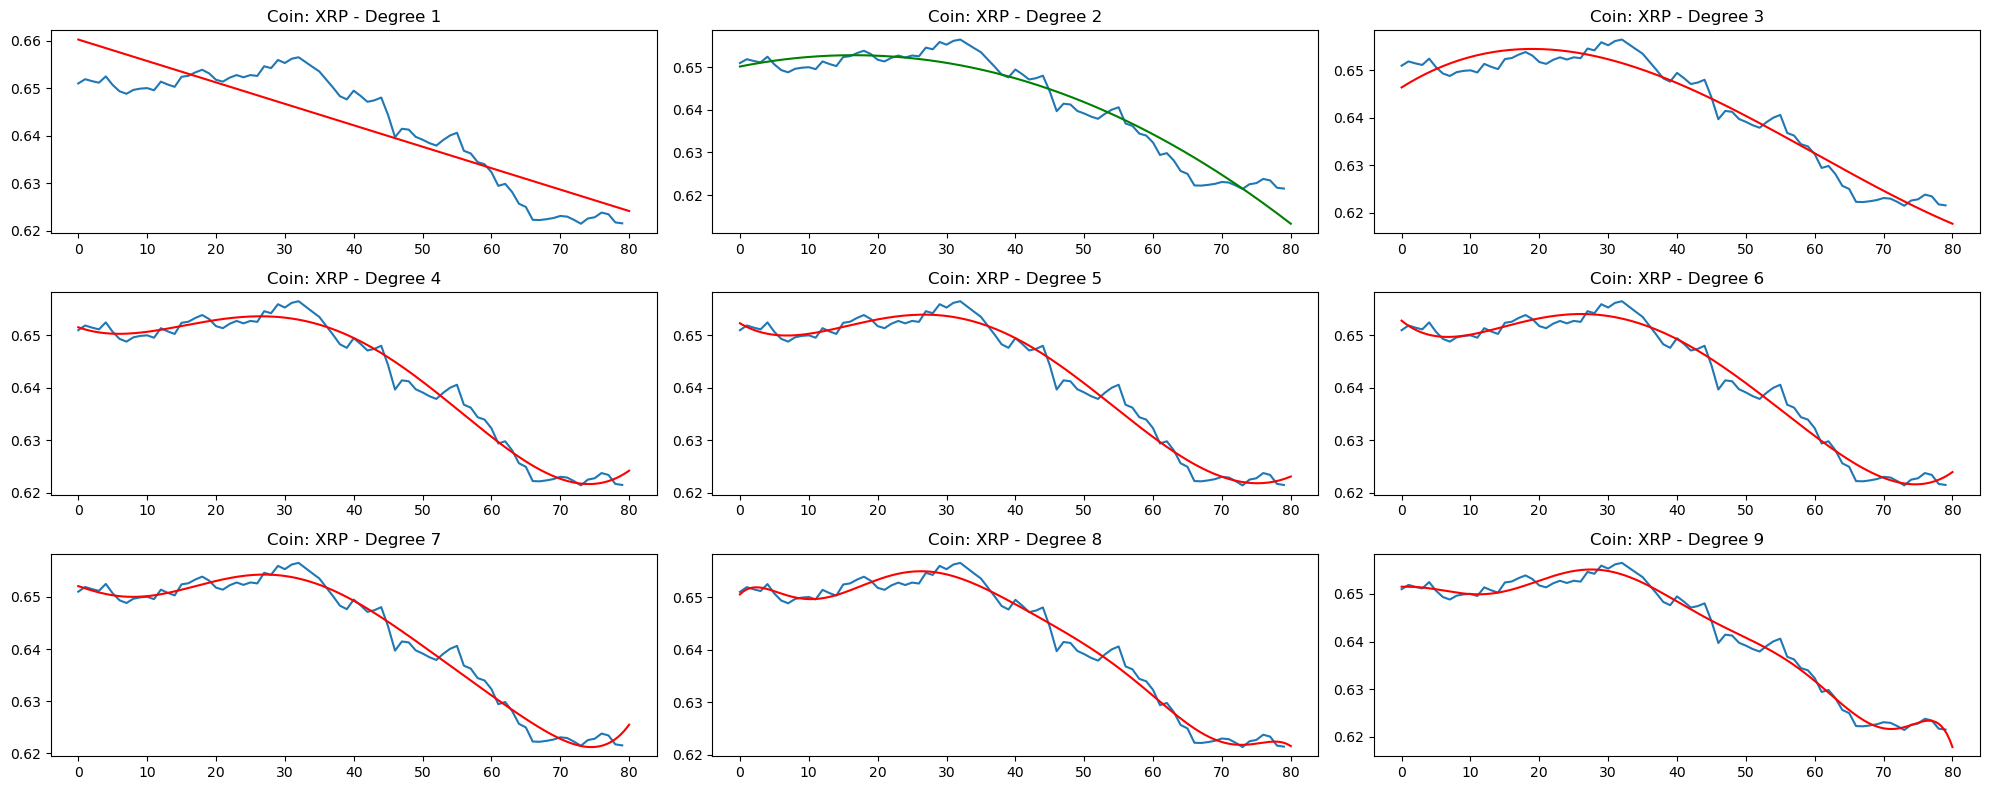

In [7]:
px = np.linspace(0, y.shape[0], 200)

trend_model = None
best_coef = None

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 8))
for i in range(1, 10):
    poly = PolynomialFeatures(degree=i)
    lr = LinearRegression()
    pipeline = make_pipeline(poly, lr)

    pipeline.fit(X.reshape(-1, 1), y)
    if i == min_d:
        trend_model = clone(pipeline)
        trend_model.fit(X.reshape(-1, 1), y)
        best_coef = (lr.coef_, lr.intercept_)
    py = pipeline.predict(px.reshape(-1, 1))

    row = (i - 1) // 3
    col = (i - 1) % 3

    ax = axes[row, col]
    ax.plot(X, y)
    color = 'g' if i == min_d else 'r'
    ax.plot(px, py, color=color)
    ax.set_title(f'Coin: {coin} - Degree {i}')

plt.tight_layout()
plt.show()

In [8]:
print('Рівняння поліному: ')
for i in range(len(best_coef[0])-1, 0, -1):
    print(f"{best_coef[0][i]}*x^{i} +", end=' ')

print(best_coef[1])

Рівняння поліному: 
-9.807731633909037e-06*x^2 + 0.0003230088716725071*x^1 + 0.6501844354413105


### So, the optimal polynomial is of degree 2.

### Algorithm for detecting anomalous measurements using the Least Squares Method (LSM):

1. Establish the boundaries of the support sample, for example, 10% of the total volume of the experimental sample. The support sample forms a "Sliding Window."

2. Use the LSM algorithm to determine parameter estimates and the standard deviation of the support sample. The support sample should be free of anomalies!

3. Shift the "Sliding Window" of the support sample by one measurement towards increasing the volume, for example, to the right.

4. Use the LSM algorithm to determine parameter estimates and the standard deviation of the new support sample.

5. Check the hypothesis - whether the standard deviation of the new support sample falls within the confidence interval +-3 standard deviations of the previous support sample.

 The first thing I do is make predictions using the obtained model above.

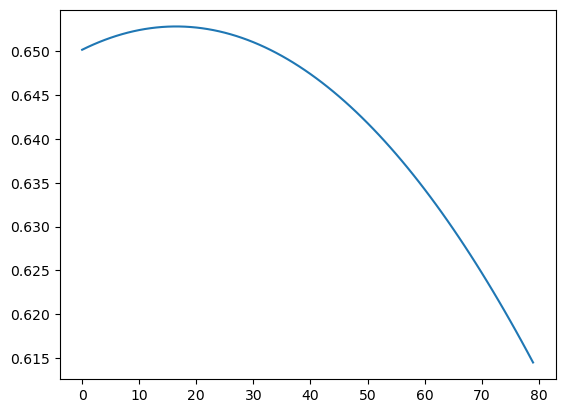

In [9]:
trend_line = trend_model.predict(np.arange(0, 80).reshape((-1, 1)))
plt.plot(trend_line)

In [10]:
n_window = 5

mse_previous = -1

emissions = []
for i in range(n_window, generated_data.shape[0]):
    cur_mse = (((generated_data[i-n_window:i] - trend_line[i-n_window:i])**2).sum())/n_window
    if mse_previous != -1:
        if cur_mse > 2*mse_previous: # тут я взяв не 3 а 2 просто того що виходило що викидів 0
            emissions.append(i)

    mse_previous = cur_mse

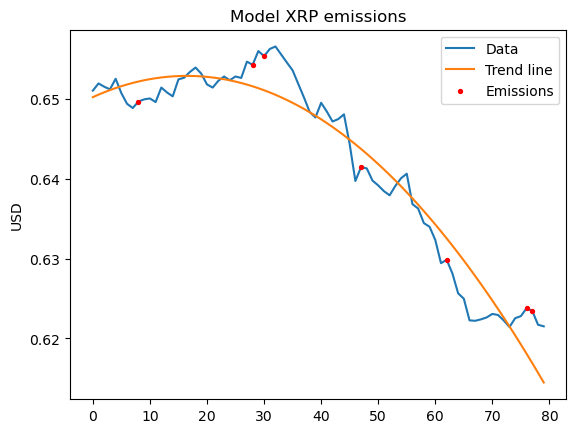

In [11]:
plt.plot(generated_data, label='Data')
plt.plot(trend_line, label='Trend line')
plt.scatter(x=emissions, y=generated_data[emissions], color='r', zorder=100, s=8, label='Emissions')
plt.ylabel('USD')
plt.title(f'Model {coin} emissions')
plt.legend()
plt.show()

### Extrapolation

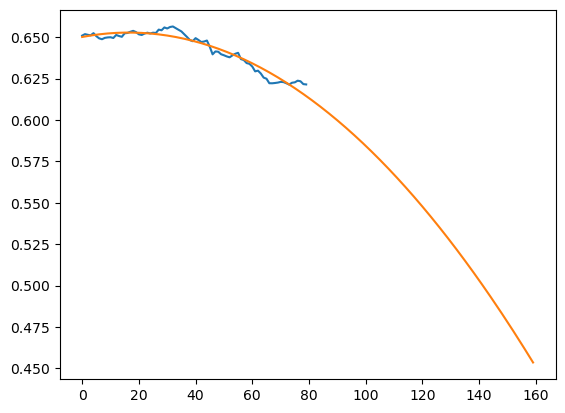

In [12]:
extrapol_line = trend_model.predict(np.arange(0, 160).reshape((-1, 1)))
plt.plot(generated_data)
plt.plot(extrapol_line)
plt.show()